# Playground for Class Imbalance Slides

- Stephen W. Thomas
- Used for MMA 869, MMAI 869, and GMMA 869

In [1]:
import datetime
print(datetime.datetime.now())

2022-07-15 14:21:44.470162


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Extreme Example

In [3]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Adopted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

def plot_boundaries(X, y, clf, clf_name, xlabel, ylabel, ax):
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02));

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]);
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1];

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8);

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cm_bright, edgecolors='k');

    ax.set_xlim(xx.min(), xx.max());
    ax.set_ylim(yy.min(), yy.max());
    ax.tick_params(axis='both', which='major', labelsize=12)
        
    ax.set_title(clf_name, fontsize=20);
    ax.grid();

    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/stepthom/869_course/main/data/generated_marketing_extreme.csv')
X = df[['Age', 'Income']].to_numpy()
y = df['Bought'].to_numpy()

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=3,
                       random_state=42)

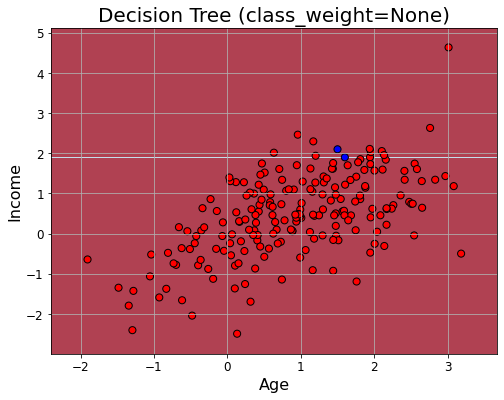

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

clf = DecisionTreeClassifier(random_state=42, 
                             criterion="entropy",
                             class_weight=None,
                             max_depth=3, 
                             max_leaf_nodes=3,
                             )
clf.fit(X, y)

figure = plt.figure(figsize=(8, 6));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X, y, clf, "Decision Tree (class_weight=None)", "Age", "Income", ax)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, max_leaf_nodes=4, random_state=42)

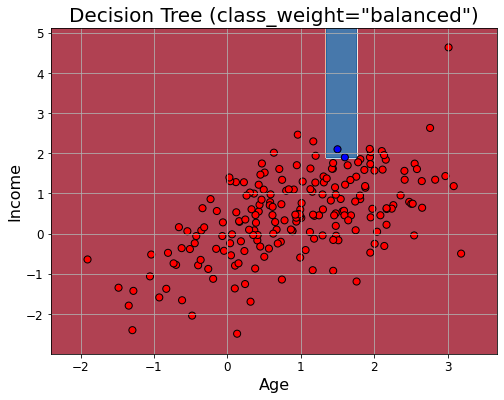

In [6]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, 
                             criterion="entropy",
                             class_weight="balanced",
                             max_depth=3, 
                             max_leaf_nodes=4,
                             )
clf.fit(X, y)

figure = plt.figure(figsize=(8, 6));
ax = plt.subplot(1, 1, 1);
plot_boundaries(X, y, clf, "Decision Tree (class_weight=\"balanced\")", "Age", "Income", ax)

# Load Dataset

The following dataset is a well-known imbalanced dataset from Kaggle:
    https://www.kaggle.com/mlg-ulb/creditcardfraud/home?select=creditcard.csv

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/stepthom/869_course/main/data/creditcard_sample.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142403 entries, 0 to 142402
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    142403 non-null  int64  
 1   V1      142403 non-null  float64
 2   V2      142403 non-null  float64
 3   V3      142403 non-null  float64
 4   V4      142403 non-null  float64
 5   V5      142403 non-null  float64
 6   V6      142403 non-null  float64
 7   V7      142403 non-null  float64
 8   V8      142403 non-null  float64
 9   V9      142403 non-null  float64
 10  V10     142403 non-null  float64
 11  V11     142403 non-null  float64
 12  V12     142403 non-null  float64
 13  V13     142403 non-null  float64
 14  V14     142403 non-null  float64
 15  V15     142403 non-null  float64
 16  V16     142403 non-null  float64
 17  V17     142403 non-null  float64
 18  V18     142403 non-null  float64
 19  V19     142403 non-null  float64
 20  V20     142403 non-null  float64
 21  V21     14

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Take a random sample, and then create X, y variables, and then split into training and testing.

In [8]:
from sklearn.model_selection import train_test_split

# This dataset is huge, so let's take a sample to speed things up
# df = df.sample(frac=0.5, replace=False, random_state=1, axis=0)
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=44)

In [9]:
y_train.value_counts()
y_test.value_counts()

0    113707
1       215
Name: Class, dtype: int64

0    28427
1       54
Name: Class, dtype: int64

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

# Helper function
def quick_evaluate_with_dt(X_train, X_test, y_train, y_test, name, balance_weights=False):
    
    cw = None
    if balance_weights == True:
        cw = 'balanced'
        
    clf = DecisionTreeClassifier(random_state=0, class_weight=cw)
    clf = RandomForestClassifier(random_state=0, n_estimators=100, class_weight=cw)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy       = accuracy_score(y_test, y_pred)
    f1             = f1_score(y_test, y_pred)
    recall         = recall_score(y_test, y_pred)
    precision      = precision_score(y_test, y_pred)
    roc_auc        = roc_auc_score(y_test, y_pred)
    
    df = pd.DataFrame({"Method"    : [name],
                       "Neg"       : [tn + fn],
                       "True Neg"  : [tn],
                       "False Neg" : [fn],
                       "Pos"       : [tp + fp],
                       "TP"        : [tp],
                       "FP"        : [fp],
                       "Accuracy"  : [accuracy],
                       "Recall"    : [recall],
                       "Precision" : [precision],
                       "F1"        : [f1],
                       "AUC"       : [roc_auc],
                      })
    
    print(df)
    return df

In [11]:
evals = list()

In [12]:
X_train.shape
y_train.shape
np.bincount(y_train)

evals.append(quick_evaluate_with_dt(X_train, X_test, y_train, y_test, 'None'))

(113922, 30)

(113922,)

array([113707,    215])

  Method    Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0   None  28435     28425         10   46  44   2  0.999579  0.814815   

   Precision    F1       AUC  
0   0.956522  0.88  0.907372  


In [13]:
X_train.shape
y_train.shape
np.bincount(y_train)

evals.append(quick_evaluate_with_dt(X_train, X_test, y_train, y_test, 'Class Weights', balance_weights=True))

(113922, 30)

(113922,)

array([113707,    215])

          Method    Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Class Weights  28435     28425         10   46  44   2  0.999579  0.814815   

   Precision    F1       AUC  
0   0.956522  0.88  0.907372  


In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test, 'Over Random'))

(227414, 30)

(227414,)

array([113707, 113707])

        Method    Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Over Random  28434     28425          9   47  45   2  0.999614  0.833333   

   Precision        F1       AUC  
0   0.957447  0.891089  0.916631  


In [15]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test, 'Over SMOTE'))

(227414, 30)

(227414,)

array([113707, 113707])

       Method    Neg  True Neg  False Neg  Pos  TP  FP  Accuracy   Recall  \
0  Over SMOTE  28428     28421          7   53  47   6  0.999544  0.87037   

   Precision        F1      AUC  
0   0.886792  0.878505  0.93508  


In [16]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN(random_state=0).fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test,  'Over ADASYN'))

(227450, 30)

(227450,)

array([113707, 113743])

        Method    Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Over ADASYN  28428     28420          8   53  46   7  0.999473  0.851852   

   Precision        F1       AUC  
0   0.867925  0.859813  0.925803  


In [17]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test,  'Under Sample'))

(430, 30)

(430,)

array([215, 215])

         Method    Neg  True Neg  False Neg  Pos  TP   FP  Accuracy    Recall  \
0  Under Sample  27874     27868          6  607  48  559  0.980162  0.888889   

   Precision        F1       AUC  
0   0.079077  0.145234  0.934612  


In [18]:
# Recall the actual distrition of the truth labels of the testing set.
y_test.value_counts()

evals_all = pd.concat([m for m in evals], axis = 0).reset_index()

evals_all = evals_all.drop(columns = "index",axis =1)
evals_all.sort_values(by=['F1'], ascending=False)

0    28427
1       54
Name: Class, dtype: int64

,Method,Neg,True Neg,False Neg,Pos,TP,FP,Accuracy,Recall,Precision,F1,AUC
2,Over Random,28434,28425,9,47,45,2,0.999614,0.833333,0.957447,0.891089,0.916631
0,None,28435,28425,10,46,44,2,0.999579,0.814815,0.956522,0.880000,0.907372
1,Class Weights,28435,28425,10,46,44,2,0.999579,0.814815,0.956522,0.880000,0.907372
3,Over SMOTE,28428,28421,7,53,47,6,0.999544,0.870370,0.886792,0.878505,0.935080
4,Over ADASYN,28428,28420,8,53,46,7,0.999473,0.851852,0.867925,0.859813,0.925803
5,Under Sample,27874,27868,6,607,48,559,0.980162,0.888889,0.079077,0.145234,0.934612


# Another Dataset

The dataset is also imbalanced, although less so. It comes from:

https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [19]:
df_d = pd.read_csv('https://raw.githubusercontent.com/stepthom/869_course/main/data/diabetes_orig.csv')
df_d.info()
df_d.head()

X = df_d.drop(['Id', 'diabetes'], axis=1)
y = df_d['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=44)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  768 non-null    int64  
 1   num_times_pregnant  768 non-null    int64  
 2   plasma_glucose      768 non-null    int64  
 3   DBP                 768 non-null    int64  
 4   triceps_skin        768 non-null    int64  
 5   serum_insulin       768 non-null    int64  
 6   BMI                 768 non-null    float64
 7   pedigree            768 non-null    float64
 8   age                 768 non-null    int64  
 9   diabetes            768 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 60.1 KB


,Id,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [20]:
y_train.value_counts()
y_test.value_counts()

0    400
1    214
Name: diabetes, dtype: int64

0    100
1     54
Name: diabetes, dtype: int64

In [21]:
evals_d = list()

In [22]:
X_train.shape
y_train.shape
np.bincount(y_train)

evals_d.append(quick_evaluate_with_dt(X_train, X_test, y_train, y_test, 'None'))

(614, 8)

(614,)

array([400, 214])

  Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0   None  116        88         28   38  26  12   0.74026  0.481481   

   Precision        F1       AUC  
0   0.684211  0.565217  0.680741  


In [23]:
X_train.shape
y_train.shape
np.bincount(y_train)

evals_d.append(quick_evaluate_with_dt(X_train, X_test, y_train, y_test, 'Class Weights', balance_weights=True))

(614, 8)

(614,)

array([400, 214])

          Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Class Weights  120        91         29   34  25   9  0.753247  0.462963   

   Precision        F1       AUC  
0   0.735294  0.568182  0.686481  


In [24]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals_d.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test, 'Over Random'))

(800, 8)

(800,)

array([400, 400])

        Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Over Random  110        86         24   44  30  14  0.753247  0.555556   

   Precision        F1       AUC  
0   0.681818  0.612245  0.707778  


In [25]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals_d.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test, 'Over SMOTE'))

(800, 8)

(800,)

array([400, 400])

       Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Over SMOTE  107        84         23   47  31  16  0.746753  0.574074   

   Precision        F1       AUC  
0   0.659574  0.613861  0.707037  


In [26]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN(random_state=0).fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals_d.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test,  'Over ADASYN'))

(775, 8)

(775,)

array([400, 375])

        Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy   Recall  \
0  Over ADASYN  101        81         20   53  34  19  0.746753  0.62963   

   Precision        F1       AUC  
0   0.641509  0.635514  0.719815  


In [27]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

X_resampled.shape
y_resampled.shape
np.bincount(y_resampled)

evals_d.append(quick_evaluate_with_dt(X_resampled, X_test, y_resampled, y_test,  'Under Sample'))

(428, 8)

(428,)

array([214, 214])

         Method  Neg  True Neg  False Neg  Pos  TP  FP  Accuracy    Recall  \
0  Under Sample   92        73         19   62  35  27  0.701299  0.648148   

   Precision        F1       AUC  
0   0.564516  0.603448  0.689074  


In [28]:
# Recall the actual distrition of the truth labels of the testing set.
y_test.value_counts()

evals_d_all = pd.concat([m for m in evals_d], axis = 0).reset_index()

evals_d_all = evals_d_all.drop(columns = "index",axis =1)
evals_d_all.sort_values(by=['F1'], ascending=False)

0    100
1     54
Name: diabetes, dtype: int64

,Method,Neg,True Neg,False Neg,Pos,TP,FP,Accuracy,Recall,Precision,F1,AUC
4,Over ADASYN,101,81,20,53,34,19,0.746753,0.629630,0.641509,0.635514,0.719815
3,Over SMOTE,107,84,23,47,31,16,0.746753,0.574074,0.659574,0.613861,0.707037
2,Over Random,110,86,24,44,30,14,0.753247,0.555556,0.681818,0.612245,0.707778
5,Under Sample,92,73,19,62,35,27,0.701299,0.648148,0.564516,0.603448,0.689074
1,Class Weights,120,91,29,34,25,9,0.753247,0.462963,0.735294,0.568182,0.686481
0,None,116,88,28,38,26,12,0.740260,0.481481,0.684211,0.565217,0.680741
